<a href="https://colab.research.google.com/github/shantanu-k/DeepLearning-Projects/blob/main/GAN_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import imageio
import glob
import matplotlib.pyplot as plt
import numpy as np
import os,time

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images  = (train_images.astype(np.float32)-127.5)/127.5
train_images = train_images.reshape(train_images.shape[0], 784)

train_images.dtype

11493376/11490434 [==============================] - 0s 0us/step


dtype('float32')

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras import initializers

In [4]:
np.random.seed(1000)
randomDim = 10
adam = Adam(learning_rate=0.002,beta_1=0.5)

In [5]:
# generator = Sequential()
# generator.add(Dense(256, input_dim = randomDim))
# generator.add(LeakyReLU(0.2))
# generator.add(Dense(512))
# generator.add(LeakyReLU(0.2))
# generator.add(Dense(1024))
# generator.add(LeakyReLU(0.2))
# generator.add(Dense(784, activation = 'tanh'))


generator = Sequential()
generator.add(Dense(256, input_dim=randomDim)) #, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

In [6]:
# discriminator = Sequential()
# discriminator.add(Dense(1024, input_dim = 784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(Dropout(0.3))
# discriminator.add(Dense(256))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(Dropout(0.3))
# discriminator.add(Dense(256))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(Dropout(0.3))
# discriminator.add(Dense(1, activation = 'sigmoid'))

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [7]:
# discriminator.trainable = False
# ganInput = Input(shape=(randomDim,))
# x =  generator(ganInput)
# ganOutput = discriminator(x)
# gan = Model(inputs = ganInput, outputs = ganOutput)

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

In [8]:
# discriminator.compile(loss = 'binary_crossentropy', optimizer = adam)
# gan.compile(loss = "binary_crossentropy", optimizer = adam)

In [9]:
# def train_gan(epochs = 1, batchSize = 128):
#     batchCount = int(train_images.shape[0] / batchSize)
#     print ('Epochs:', epochs)
#     print ('Batch size:', batchSize)
#     print ('Batches per epoch:', batchCount)
    
#     for e in range(1,epochs+1):
#         print('-'*15, 'Epoch %d' % e, '-'*15)
#         for i in range(batchCount):
#             noise = np.random.normal(0,1,size = [batchSize,randomDim])
#             dataBatch = train_images[np.random.randint(0,train_images.shape[0],size = batchSize)]

#             generatedImages = generator.predict(noise)
#             X = np.concatenate([dataBatch,generatedImages])
#             yDis = np.zeros(2*batchSize)
#             yDis[:batchSize] = 1
#             # Discriminiator Training
#             discriminator.trainable = True
#             dloss = discriminator.train_on_batch(X, yDis)
#             #Generator Training
#             noise = np.random.normal(0, 1, size=[batchSize, randomDim])
#             yGen = np.ones(batchSize)   
#             discriminator.trainable = False
#             gloss = gan.train_on_batch(noise, yGen)
#             # Record Losses
#         print(dloss, gloss)
#         dlosses.append(dloss)
#         glosses.append(gloss)

    # if e == 1 or e % 4 == 0:
    #     saveGeneratedImages(e)


def train(epochs=1, batchSize=128):
    batchCount = int(train_images.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = train_images[np.random.randint(0, train_images.shape[0], size=batchSize)]
            imageBatch  = imageBatch + np.random.normal(0,0.25, size= imageBatch.shape)
            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

In [10]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [11]:
def saveGeneratedImages(epoch, examples=100, dim=(10, 10),figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='bilinear',
        cmap='gray_r')
        plt.axis('off')
        plt.tight_layout()
        # plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [12]:
dlosses = []
glosses = []
train(epochs = 30)

Epochs: 30
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
--------------- 

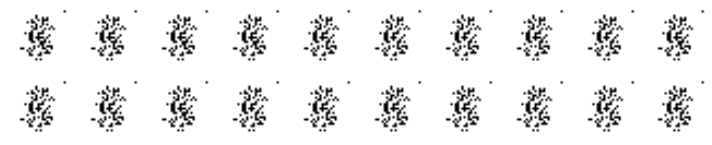

In [13]:
saveGeneratedImages(1, examples = 20)

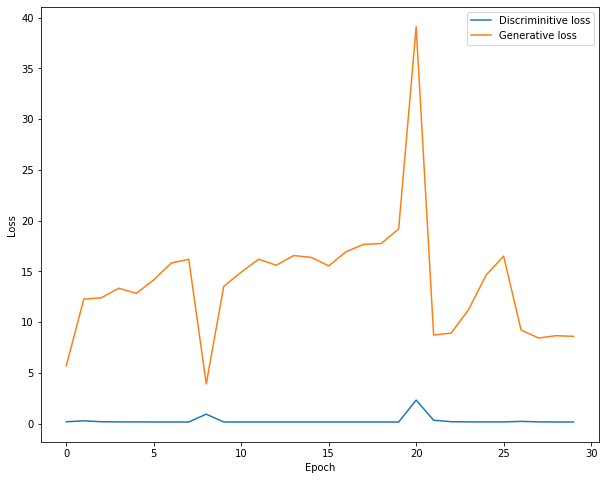

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(dLosses, label='Discriminitive loss')
plt.plot(gLosses, label='Generative loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [15]:
batchSize = 10
noise = np.random.normal(0, 1, size=[batchSize, randomDim])
# yGen = np.ones(batchSize)   
# discriminator.trainable = False
# gloss = gan.train_on_batch(noise, yGen)

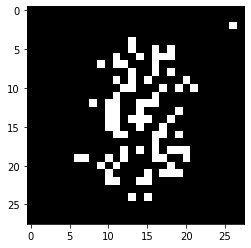

In [25]:
img = generator.predict(noise).reshape(-1,28,28)
plt.imshow(img[1], cmap = "gray")

In [17]:
discriminator.trainable = True
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1463312   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 2,923,537
Non-trainable params: 0
_________________________________________________________________


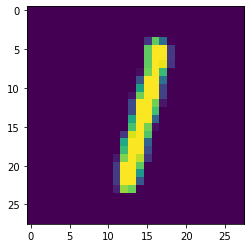

In [22]:
dataBatch = train_images[np.random.randint(0,train_images.shape[0],size = 10)]
plt.imshow(dataBatch[5].reshape(28,28))

In [23]:
discriminator.predict(np.concatenate([dataBatch,generator.predict(noise)]))

array([[8.9490902e-01],
       [8.8458550e-01],
       [8.8859779e-01],
       [9.0359437e-01],
       [8.7242281e-01],
       [8.9777517e-01],
       [9.2057222e-01],
       [9.0295249e-01],
       [8.9261293e-01],
       [8.8211060e-01],
       [1.4865398e-04],
       [1.5512109e-04],
       [1.4352798e-04],
       [1.4552474e-04],
       [1.4644861e-04],
       [1.4352798e-04],
       [1.4352798e-04],
       [1.4865398e-04],
       [1.4558434e-04],
       [1.4352798e-04]], dtype=float32)

In [20]:
gan.predict(noise)

array([[0.00014865],
       [0.00015512],
       [0.00014353],
       [0.00014552],
       [0.00014645],
       [0.00014353],
       [0.00014353],
       [0.00014865],
       [0.00014552],
       [0.00014353]], dtype=float32)